*Problem 1.4. Consider the generalized Ising model in a modulated transverse field.*
$$
H=H_P+H_D=\sum_{i,j=0}^{n-1}J_{ij}\sigma_i^z\sigma_{j}^z + h(s)\sum_{i=0}^{n-1}\sigma_i^x
$$
*with $s=t/T$. Write a code that performs a quantum annealing to find the ground state of $H_P$.  Use for $J_{ij}$ different options*

In the quantum annealing framework we can define $H_P$ as the problem Hamiltonian (encodes the cost function) and the transverse field $H_D$ as the driver Hamiltonian (it randomizes the quantum state as would to the temperature.  $h(s)$ would be the annealing schedule, with $s=t/T $ as the annealing parameter that goes from $0$ to $1$ as the time $t$ goes from $0$ to the total annealing time $T$.
We will use a simple linear schedule: $h(s)=h(0)(1-s)$

At $s=0$ $h(s)$ is proposed to be large, to enforce quantum fluctuations and then it decreases smoothly to $h(s)=0$ at $s=1$ so that the system ideally ends in the ground state of $H_P$.

Ground state energy of H_P: -4.999940
Ground state of H_P:
0.447 + -0.222j |001000⟩
-0.448 + 0.223j |001100⟩
-0.448 + 0.223j |110011⟩
0.447 + -0.222j |110111⟩


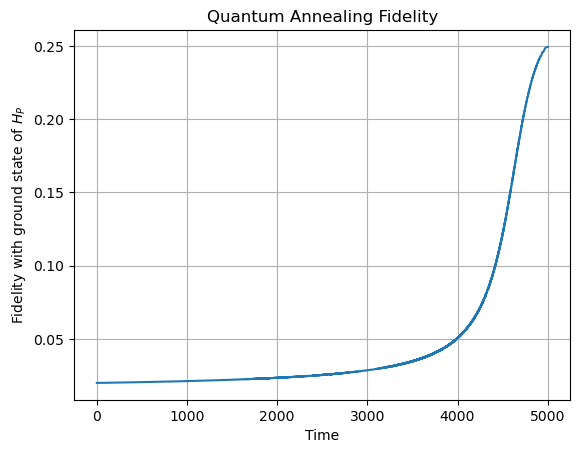

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm


# Define the Pauli matrices
#-------------------------------------
si = np.array([[1, 0], [0, 1]])
sx = np.array([[0, 1], [1, 0]])
sz = np.array([[1, 0], [0, -1]])

# Define a Kronecker product of N operators
#----------------------------------------------
def kron_N(*ops):
    out = ops[0]
    for op in ops[1:]:
        out = np.kron(out, op)
    return out
    
# Define the driver Hamiltonian
#----------------------------------------------
def H_driver(n):
    Hx = np.zeros((2**n, 2**n), dtype=complex)
    for i in range(n):
        ops = [si]*n
        ops[i] = sx
        Hx += kron_N(*ops)
    return Hx

# Define the problem Hamiltonian
#----------------------------------------------
def H_problem(n, J_matrix):
    H = np.zeros((2**n, 2**n), dtype=complex)
    for i in range(n):
        for j in range(i+1,n):# only upper triangle (i < j), since J is symmetric
            Jij=J_matrix[i,j]
            if Jij !=0:   # the only terms in H correspond to non-zero couplings
                ops=[si]*n
                ops[i]=sz
                ops[j]=sz
                H += Jij*kron_N(*ops)
    return H


# Define the annealing schedule
#----------------------------------------------
def h_schedule(s, h0):
    # linear schedule
    return h0 * (1 - s)   # returns the transverse field at time s


# Build the time-dependent Hamiltonian
#----------------------------------------------
def TD_H(t, T, H_P, H_D, h0):
    s = t / T
    return H_P + h_schedule(s, h0) * H_D


# Evolve psi using exact matrix exponentiation
#-----------------------------------------------
def time_ev(psi0, H_func, tlist):   # initial state, function to calculate H(t), array of discrete time points t 
    psi = psi0.copy()         # initial state vector
    psi_t = [psi0.copy()]  # the first element in the list is the initial state
    dt = tlist[1] - tlist[0]  # time step (tlist has equal spacing)

    for t in tlist[:-1]:   # iterate over all time points except the last (we don't evolve from there)
        H = H_func(t)
        U = expm(-1j * H * dt)
        psi = U @ psi     # evolve the state one step forward psi(t+dt)= U*psi(t)
        psi_t.append(psi.copy())   # store the new state in the list
    return np.array(psi_t)     # an array of state vectors psi(t) at each time in tlist



# START PROGRAM
#-----------------------------------------------------
# General parameters
#-----------------------------------------------------
n=6 # number of spins
h0=10  # initial transverse field at s=0
#T=1000   # annealing time
T=5000
steps=10000
tlist = np.linspace(0, T, steps)




# Generate matrices with the coupling constants
#-----------------------------------------------------
J_matrix_all_to_all = np.zeros((n, n))    # all-to-all interactions
# Fill in symmetric non-diagonal values using nested loops
# diagonal values need to be 0 to avoid self-interaction
# all off-diagonal values = 1 (fully connected Ising model)
for i in range(n):
    for j in range(i + 1, n):  # i < j to avoid double counting and diagonal
        J_matrix_all_to_all[i, j] = 1.0    # or any function of (i,j)
        #J_matrix_all_to_all[i, j] = -1.0    # or any function of (i,j)                        # CHOOSE J=1 OR J=-1 HERE
        J_matrix_all_to_all[j, i] = J_matrix_all_to_all[i, j]  # ensure symmetry
#-------------------------------------------------------
#a  matrix J_ij with long range decaying values 1/|i-j|^alpha'
def J_nonlocal_chain(n, J,alpha):
    matrix = np.zeros((n, n))
    for i in range(n-1):
        for j in range(i+1,n):
            matrix[i, j] = J/abs(i-j)**alpha
            matrix[j, i] = matrix[i, j]
    return matrix
#-------------------------------------------------------
#a random J_ij matrix with values J_ij  randomly chosen in [0,+J,-J]
def J_random_pmJ(n,J):
    matrix = np.random.choice([0, J, -J], size=(n, n))
    matrix = (matrix + matrix.T) // 2  # Make the matrix symmetric
    np.fill_diagonal(matrix, 0)  # No self-interactions
    return matrix

#-----------------------------------------------------------------------
# CHOOSE ONE COUPLING MATRIX HERE (uncomment)
#-----------------------------------------------------------------------
#J_matrix=J_matrix_all_to_all    # all-to-all interactions
#J_matrix=J_nonlocal_chain(n,J=-1,alpha=2)   # Moderately long-range	
#J_matrix=J_nonlocal_chain(n,J=1,alpha=1)   # Power-law decay long-range
#J_matrix=J_nonlocal_chain(n,J=1,alpha=4)   # short-range, almost nearest-neighbors
#J_matrix=J_nonlocal_chain(n,J=1,alpha=9999999)   # nearest-neighbors only
J_matrix=J_random_pmJ(n,J=-1)     # random couplings


# Build Hamiltonians
#----------------------------------------
H_P = H_problem(n, J_matrix)
H_D = H_driver(n)


# Initial state: ground state of H_D   
# We can assume that H(0) \approx h0H_D so the GS of H(0) is approx the GS of H_D
# If h(0) is no large enough compared to ||H_P||, we should diagonalize H(0) instead
#-----------------------------------------------------------------------------------
#eigvals, eigvecs = np.linalg.eigh(H_D) 
#psi0 = eigvecs[:, 0]  # ground state of H_D (most negative eigenvalue)
t=0
H0 = TD_H(t, T, H_P, H_D, h0)
eigvals, eigvecs = np.linalg.eigh(H0) 
psi0 = eigvecs[:, 0]


# Function to generate the time-dependent Hamiltonian 
#--------------------------------------------------------
def H_func(t):
    return TD_H(t, T, H_P, H_D, h0)  # we need to do use this as a wrapper to pass a function with just 
    # one variable to time_ev. This way we bound the other arguments (T, H_P, etc.) and 
    # H_func depends only on t.


# Time evolution
#--------------------------------------------
psi_t = time_ev(psi0, H_func, tlist)


# Print the ground state (the final state in the psi_t list)
#------------------------------------------------------------
def pretty_print_state(state_vector, tol=1e-3):
    n = int(np.log2(len(state_vector)))  # Number of qubits
    for i, amp in enumerate(state_vector):
        if np.abs(amp) > tol:
            bstr = format(i, f'0{n}b')  # Binary string with leading zeros
            amp_str = f"{amp.real:.3f}" + (f" + {amp.imag:.3f}j" if abs(amp.imag) > 1e-6 else "")
            print(f"{amp_str} |{bstr}⟩")
            
psi_final=psi_t[-1]   # last element of my list of states
E_GS = np.real(np.vdot(psi_final, H_P @ psi_final))


print(f"Ground state energy of H_P: {E_GS:.6f}")
print("Ground state of H_P:")
pretty_print_state(psi_final)
            

# Fidelity with ground state of H_P
#--------------------------------------------
E_P, eigs_P = np.linalg.eigh(H_P)   # diagonalizes the problem Hamiltonian
psi_gs = eigs_P[:, 0]      # the ground state is the eigenvector corresponding to the lowest eigenvalue
                           # the first column for a Hermitian matrix such as H_P
fidelity = np.abs(np.dot(np.conj(psi_gs), psi_t.T))**2
#psi_t.T  # tranpose of the matrix that contains the evolved states psi(t)
#np.conj(psi_gs)  # complex conjugate of the GS of H_P
#np.dot(np.conj(psi_gs), psi_t.T)   is an array of overlaps between the GS and the psi(t)
#the square of this value is the fidelity

#fidelity is an array providing the probability that the system is in the ground state of H_P at each time step

# Plot
plt.plot(tlist, fidelity)
plt.xlabel("Time")
plt.ylabel("Fidelity with ground state of $H_P$")
plt.title("Quantum Annealing Fidelity")
plt.grid(True)
plt.show()





For many of the chosen $J_{ij}$ matrices there is high degeneracy on the spectrum of $H_P$, so we calculate the fidelity projecting into the set of degenerate eigenvectors corresponding to the ground state (those with the lowest eigenvalue).

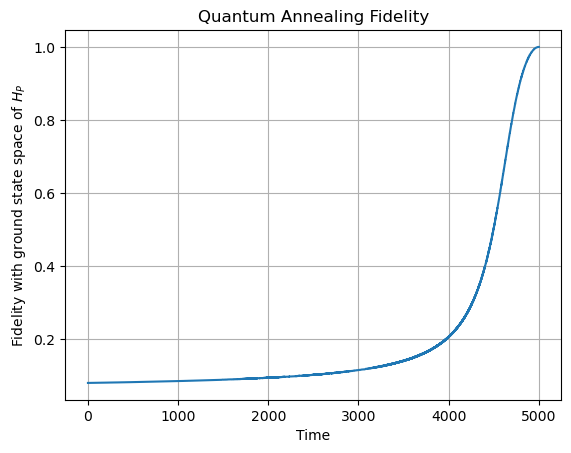

In [2]:
# Re-diagonalize H_P just to be sure
eigvals, eigs_P = np.linalg.eigh(H_P)

# Identify degenerate ground states
tol = 1e-6
gs_energy = eigvals[0]
degenerate_indices = np.where(np.abs(eigvals - gs_energy) < tol)[0]
gs_vectors = eigs_P[:, degenerate_indices]

# Projector onto ground state space
P_gs = gs_vectors @ gs_vectors.conj().T

# Always use a fresh copy of psi_t
psi_t_proj = psi_t.copy()

# Compute fidelity at each time step
fidelity_all = []
for psi in psi_t_proj:
    fidelity_all.append(np.real(np.vdot(psi, P_gs @ psi)))  # vdot handles conjugation
fidelity_all = np.array(fidelity_all)

# Plot
plt.plot(tlist, fidelity_all)
plt.xlabel("Time")
plt.ylabel("Fidelity with ground state space of $H_P$")
plt.title("Quantum Annealing Fidelity")
plt.grid(True)
plt.show()



We have run the code for n=5 and n=6, introducing some variation in the parameters used in order to explore the main dependencies.

Fidelity of the state evolved through the annealing scheme with the state obtained by direct diagonalization of the target Hamiltonian ($H_P$) is a good measurement of the quality of the simulation. Fidelities of one (or very close to it) indicate that the annealing has produced the desired ground state. 

Nevertheless, there is a caveat when this ground state is degenerate, something that is not uncommon at all in the modeling of spin systems (at least with the coupling schemes that I have tried in this work). In this case, the  values of  fidelity  at $T$ match well the degeneracy of the ground state: when there are eight states with the same energy, we get a fidelity value of 0.125, when there are two, 0.5, etc. When $\psi(T)$ is projected onto the vector subspace of the ground state, the resultant fidelity is 1, as desired.

For **n=5**, large annealing times (T=1000) and also large values of the transverse field (h0=10), which make the use of the ground state of $H_D$ as the initial state to propagate  a good choice, the evolution of the system led to the ground state of $H_P$ (fidelities of 1 after projection into the subspace of degenerate states associated to the lowest eigenvalue) in all runs, with different choices of $J_{ij}$ matrix and of J (either -1 or +1).  T=25 leads to fidelities that don't reach one but are rather close (although it might not be possible to correctly identify the ground state from these simulations). If T=25 with a larger value of h0 (h0=100), this time is clearly not enough, with projected fidelities around 0.3 for random $J_{ij}$ couplings.

For all-to-all coupling, with $J=-1$ the ground state is a linear combinations of  $\left|00000 \right>$ and $\left|11111\right>$ (ferromagnetic). When $J=1$, the ground state is a linear combination of the states with 3 spins up and 2 down and viceversa (20-fold degeneracy).
For nearest neighbors and $J=1$, the ground state is a linear combination of the alternating states $\left|10101 \right>$ and $\left|01010\right>$ and for $J=-1$ of the states all-up and all-down. 

For **n=6**  T=50 is not enough for h0=10 (fidelity is lower than one, albeit quite close to it). When looking at fidelity values, T=100 seems enough for random couplings, but not for full all-to-all coupling or even a non-local chain with $\alpha=2$. T=200  consistently leads to an identifiable ground state also in these cases. Nevertheless (see below) T values of around 2500 are needed to get a  well-defined ground state.

Note: these values are also affected by the choice of schedule (which I didn't change) and the actual value of J, which I made 1 or -1 in all cases.

For an all-to-all or nearest neighbor coupling with J=-1, the ground state is two-fold degenerate: with linear combinations of  $\left|000000 \right>$ and $\left|111111\right>$ (ferromagnetic). Values of T=50 start providing some mixing with states with one spin flip, but T=100 ensures convergence towards the correct ground state.

When J=1 in the all-to-all coupling scheme, however, the degeneracy of the ground state (with three spins up and three spins down) is much higher (20-fold).
If we want these more complex states well described, with a very low contamination of the ground state with lower lying excited states (in this case, those with four spins up/two down and two spins up/four down), it is advisable to increase the annealing times up to T=1000 (or even T=2500 if we want the coefficients of these states to fall below the cutoff I've chosen for printing). 

When dealing with the nearest-neighbor model, and J=1, T=2500 is again needed. The ground state is a linear combination of the two states with alternating spins:  $\left|101010 \right>$ and $\left|010101\right>$. When J=-1, the ground state is $\left|000000 \right>$ and $\left|111111\right>$.

If the model for spin-couplings is a non-local chain with $\alpha=2$ with $J=-1$ we get as ground state a combination of $\left|101010 \right>$   and $\left|010101\right>$, and in the case if $J=1$, $\left|000000 \right>$ and $\left|111111\right>$, as in the nearest neighbor model.

If we choose random matrices, there is more variety of ground states available. When $J=-1$, the ground state becomes a linear combination of $\left|000000 \right>$ and $\left|111111\right>$, but  when $J=1$, the ground state is a linear combination of $\left|001100 \right>$ and $\left|110011\right>$. The ground state found for a different random matrix is a combination of   $\left|001101 \right>$ , $\left|001111\right>$, $\left|110000 \right>$ and $\left|110010\right>$, etc.


Note: $J>0$ and $J<0$ are inverted with respect to what is commonly used, because the terms of the Hamiltonian we have defined don't have a minus sign in front.

*In the cell below, we have some code that may be useful for diagnosis. It calculates the gap between the ground and first excited state of TD_H. If the gap is small, it is harder to preserve adiabaticity. In most cases we find that at the end of the annealing the gap becomes zero because the ground state of $H_P$ is usually degenerate (there is high symmetry in the system).
By printing the lowest eigenvalues of $H_P$ we can find the number of degenerate states at the ground state, which helps make sense of our fidelity results.*

Time: 1000
Lowest eigenvalues of TD_H: [-5. -5. -5. -5. -3. -3. -3. -3. -3. -3.]
Time: 1000
Lowest eigenvalues of H_P: [-5. -5. -5. -5. -3. -3. -3. -3. -3. -3.]


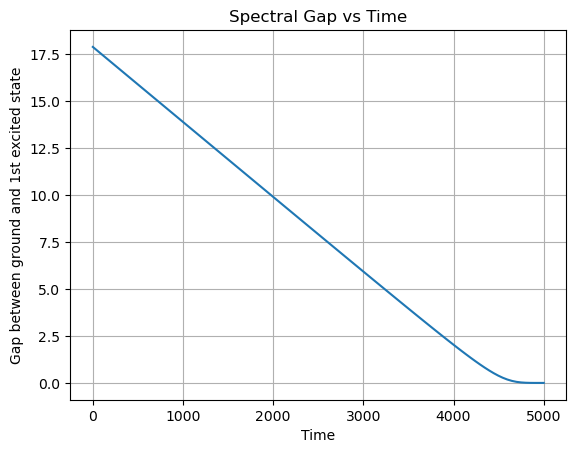

In [3]:
# gap between GS and first excited state, if it becomes small
# T needs to be much longer to preserve adiabaticity
#---------------------------------------------------------------
gaps = []
ts = np.linspace(0, T, 100)
for t in ts:
    H = TD_H(t, T, H_P, H_D, h0)
    eigvals = np.linalg.eigvalsh(H)
    gap = eigvals[1] - eigvals[0]
    #print("Gap in TD_H:",gap, "at t=",t)
    gaps.append(gap)

t=1000
H = TD_H(t, T, H_P, H_D, h0)
eigvals = np.linalg.eigvalsh(H_P)
print("Time:", t)
print("Lowest eigenvalues of TD_H:", eigvals[:10])
eigvals = np.linalg.eigvalsh(H_P)
print("Time:", t)
print("Lowest eigenvalues of H_P:", eigvals[:10])

# These eigenvalues are the same, TD_H is H_P at t=T


plt.plot(ts, gaps)
plt.xlabel("Time")
plt.ylabel("Gap between ground and 1st excited state")
plt.title("Spectral Gap vs Time")
plt.grid(True)
plt.show()



